In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from denstream import DenStream, DenStreamMicroCluster

In [3]:
import numpy as np
import time
from matplotlib import pyplot as plt
from collections import deque

from river.stream import iter_array
from river.cluster import DenStream as DenStreamOld

# Test the Micro-Clusters

## Initialization

In [4]:
# Single point
x = np.arange(10)
cluster = DenStreamMicroCluster(
    X=x,
    timestamp=1,
    decaying_factor=0.5,
)
assert cluster.last_edit_time == 1
assert cluster.creation_time == 1
assert cluster.decaying_factor == 0.5
assert np.allclose(cluster._cf1, x)
assert np.allclose(cluster._cf2, x**2)
assert cluster._w == 1

In [5]:
# Multi-point
x = np.arange(50).reshape(5,10)
cluster = DenStreamMicroCluster(
    X=x,
    timestamp=1,
    decaying_factor=0.5,
)
assert cluster.last_edit_time == 1
assert cluster.creation_time == 1
assert cluster.decaying_factor == 0.5
assert np.allclose(cluster._cf1, np.sum(x, axis=0))
assert np.allclose(cluster._cf2, np.sum(x**2, axis=0))
assert cluster._w == len(x)

## Fading Function

In [6]:
cluster = DenStreamMicroCluster(
    X= np.array([1,2,3]),
    timestamp=1,
    decaying_factor=0.5,
)
assert np.allclose(cluster.fading_function(1) * cluster.fading_function(1), cluster.fading_function(2))
assert np.allclose(cluster.fading_function(1) * cluster.fading_function(4), cluster.fading_function(5))
assert np.allclose(cluster.fading_function(31) * cluster.fading_function(17), cluster.fading_function(48))

## Update Method

Since the `_w` variable is equal to the weight when the cluster has been updated, this also tests the weight computation.

In [7]:
X = np.arange(10)
cluster = DenStreamMicroCluster(
    X=X,    # Single point
    timestamp=0,
    decaying_factor=0.5,
)

t = 1
factor = cluster.fading_function(t)
cluster._update(timestamp=t)
assert cluster.last_edit_time == t
assert np.allclose(cluster._cf1, X*factor)
assert np.allclose(cluster._cf2, (X**2)*factor)
assert np.allclose(cluster._w, factor)

t = 10
factor = cluster.fading_function(t)
cluster._update(timestamp=t)
assert cluster.last_edit_time == t
assert np.allclose(cluster._cf1, X*factor)
assert np.allclose(cluster._cf2, (X**2)*factor)
assert np.allclose(cluster._w, factor)

In [8]:
X = np.arange(50).reshape(5,10)
cluster = DenStreamMicroCluster(
    X=X,    # Multi-point
    timestamp=0,
    decaying_factor=0.5,
)

t = 1
factor = cluster.fading_function(t)
cluster._update(timestamp=t)
assert cluster.last_edit_time == t
assert np.allclose(cluster._cf1, np.sum(X*factor, axis=0))
assert np.allclose(cluster._cf2, np.sum(X**2*factor, axis=0))
assert np.allclose(cluster._w, len(X)*factor)

t = 10
factor = cluster.fading_function(t)
cluster._update(timestamp=t)
assert cluster.last_edit_time == t
assert np.allclose(cluster._cf1, np.sum(X*factor, axis=0))
assert np.allclose(cluster._cf2, np.sum(X**2*factor, axis=0))
assert np.allclose(cluster._w, len(X)*factor)

## Insert Method

This method is further tested in the center and radius computations later.

In [9]:
X = np.arange(80).reshape(8,10)
cluster = DenStreamMicroCluster(
    X=X[:4],
    timestamp=0,
    decaying_factor=0.5,
)

cluster.insert(X[4], timestamp=0)   # Same timestamp
assert cluster.last_edit_time == 0
assert np.allclose(cluster._cf1, np.sum(X[:5], axis=0))
assert np.allclose(cluster._cf2, np.sum(X[:5]**2, axis=0))
assert np.allclose(cluster._w, 5)

t = 5
cluster.insert(X[5:], timestamp=t)
factor = cluster.fading_function(t)
assert cluster.last_edit_time == t
assert np.allclose(cluster._cf1, np.sum(X[:5]*factor, axis=0) + np.sum(X[5:], axis=0))
assert np.allclose(cluster._cf2, np.sum(X[:5]**2*factor, axis=0) + np.sum(X[5:]**2, axis=0))
assert np.allclose(cluster._w, 5*factor + 3)

## Calculate Center and Radius

In [6]:
def get_faded_factors(time_dict, current_time):
    fading_function = lambda t: 2 ** (-0.5 * t)
    factors = []
    for time, num_points in time_dict.items():
        factor = fading_function(current_time - time)
        factors.extend([[factor]] * num_points)
    return np.array(factors)

In [7]:
X = np.arange(80).reshape(8,10)
cluster = DenStreamMicroCluster(
    X=X[:5],
    timestamp=0,
    decaying_factor=0.5,
)

assert np.allclose(cluster.calc_weight(0), len(X[:5]))
assert np.allclose(cluster.calc_center(0), np.mean(X[:5], axis=0))
assert np.allclose(cluster.calc_radius(0), np.linalg.norm(np.std(X[:5], axis=0)))

t=2
cluster.insert(X[5], timestamp=t)
factors = get_faded_factors({0: 5, 2: 1}, t)
assert np.allclose(cluster.calc_weight(t), np.sum(factors))
weighted_center = np.average(X[:6], axis=0, weights=factors.flatten())
assert np.allclose(cluster.calc_center(t), weighted_center)
weighted_variance = np.average((X[:6] - weighted_center)**2, axis=0, weights=factors.flatten())
assert np.allclose(cluster.calc_radius(t), np.linalg.norm(np.sqrt(weighted_variance)))

t=5
cluster.insert(X[6:], timestamp=t)
factors = get_faded_factors({0: 5, 2: 1, 5:2}, t)
assert np.allclose(cluster.calc_weight(t), np.sum(factors))
weighted_center = np.average(X, axis=0, weights=factors.flatten())
assert np.allclose(cluster.calc_center(t), weighted_center)
weighted_variance = np.average((X - weighted_center)**2, axis=0, weights=factors.flatten())
assert np.allclose(cluster.calc_radius(t), np.linalg.norm(np.sqrt(weighted_variance)))

t = 10
factors = get_faded_factors({0: 5, 2: 1, 5:2}, t)
assert np.allclose(cluster.calc_weight(t), np.sum(factors))
weighted_center = np.average(X, axis=0, weights=factors.flatten())
assert np.allclose(cluster.calc_center(t), weighted_center)
weighted_variance = np.average((X - weighted_center)**2, axis=0, weights=factors.flatten())
assert np.allclose(cluster.calc_radius(t), np.linalg.norm(np.sqrt(weighted_variance)))

## Merge

In [12]:
X = np.arange(100).reshape(10,10)
cluster1 = DenStreamMicroCluster(
    X=X[:5],
    timestamp=0,
    decaying_factor=0.5,
)
cluster2 = DenStreamMicroCluster(
    X=X[5:],
    timestamp=0,
    decaying_factor=0.5,
)
cluster1.merge(cluster2)
assert np.allclose(cluster1._cf1, np.sum(X, axis=0))
assert np.allclose(cluster1._cf2, np.sum(X**2, axis=0))
assert np.allclose(cluster1._w, len(X))

In [13]:
X = np.arange(120).reshape(12,10)
cluster1 = DenStreamMicroCluster(
    X=X[:5],
    timestamp=0,
    decaying_factor=0.5,
)

cluster1.insert(X[5], timestamp=3)

cluster2 = DenStreamMicroCluster(
    X=X[6:10],
    timestamp=5,
    decaying_factor=0.5,
)

cluster2.insert(X[10:], timestamp=8)

cluster1.merge(cluster2)
factors = get_faded_factors({0: 5, 3: 1, 5:4, 8:2}, 8)
assert np.allclose(cluster1._cf1, np.sum(X * factors, axis=0))
assert np.allclose(cluster1._cf2, np.sum(X**2 * factors, axis=0))
assert np.allclose(cluster1._w, np.sum(factors))

t = 10
factors = get_faded_factors({0: 5, 3: 1, 5:4, 8:2}, t)
cluster1._update(timestamp=t)
assert np.allclose(cluster1._cf1, np.sum(X * factors, axis=0))
assert np.allclose(cluster1._cf2, np.sum(X**2 * factors, axis=0))
assert np.allclose(cluster1._w, np.sum(factors))

# Test the DenStream Clustering Algorithm

## Basic Instantiation

In [14]:
clusterer = DenStream(  # Default values
    decaying_factor = 0.25,
    beta = 0.75,
    mu = 2,
    epsilon = 0.02,
    n_samples_init = 1000,
    stream_speed = 100,
)

In [15]:
try:
    clusterer = DenStream(  # Erroneous values
        decaying_factor = 0.25,
        beta = 1.75,        # beta > 1
        mu = 2,
        epsilon = 0.02,
        n_samples_init = 1000,
        stream_speed = 100,
    )
    assert False
except ValueError:
    print("Successfully threw a ValueError")
    pass

try:
    clusterer = DenStream(  # Erroneous values
        decaying_factor = 0.25,
        beta = .25,
        mu = 2,             # mu < 1/beta
        epsilon = 0.02,
        n_samples_init = 1000,
        stream_speed = 100,
    )
    assert False
except ValueError:
    print("Successfully threw a ValueError")
    pass

Successfully threw a ValueError
Successfully threw a ValueError


## Initial DBSCAN

Do debugging/testing of the `_initial_dbscan` method.

In [16]:
clusterer = DenStream(
        decaying_factor = 0.25,
        beta = .5,
        mu = 2.5,
        epsilon = .5,
        n_samples_init = 10,
        stream_speed = 100,
    )
X = [
    [-1, -0.5], [-1, -0.625], [-1, -0.75], [-1, -1], [-1, -1.125],
    [-1, -1.25], [-1.5, -0.5], [-1.5, -0.625], [-1.5, -0.75], [-1.5, -1],
    [-1.5, -1.125], [-1.5, -1.25], [1, 1.5], [1, 1.75], [1, 2],
    [4, 1.25], [4, 1.5], [4, 2.25], [4, 2.5], [4, 3],
    [4, 3.25], [4, 3.5], [4, 3.75], [4, 4],
]

clusterer._init_buffer = [x for x in X]

start = time.time()
clusterer._initial_dbscan()
print(f"Time taken: {time.time() - start}")

clusterer.p_micro_clusters

Time taken: 0.001123666763305664


It runs, but now I need to determine if it is doing what it is supposed to do.



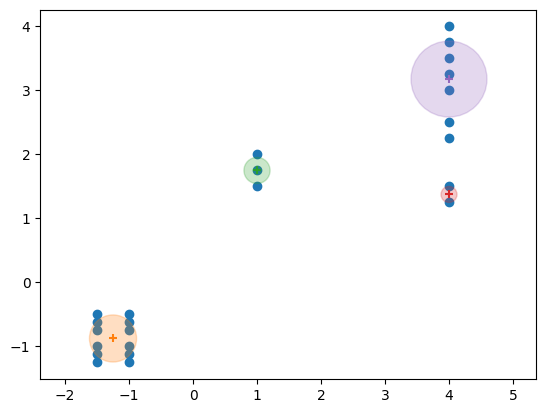

In [17]:
def plot_micro_clusters(micro_clusters, t=0):
    for cluster in micro_clusters:
        center = cluster.calc_center(t)
        radius = cluster.calc_radius(t)
        weight = cluster.calc_weight(t)
        center_point = plt.scatter(*center, marker="+", alpha=1)
        circle = plt.Circle(center, radius, fill=True, alpha=0.25, color=center_point.get_facecolor())
        plt.gca().add_patch(circle)
        plt.axis('equal')

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.p_micro_clusters)
plt.show()

Looks right. Plus with adjusting the parameters the micro_clusters are changing to what I would expect.

### Compare to the Old DenStream version

In [18]:
old_clusterer = DenStreamOld(
        decaying_factor = 0.25,
        beta = .5,
        mu = 2.5,
        epsilon = .5,
        n_samples_init = 10,
        stream_speed = 100,
    )

old_clusterer._init_buffer = deque(DenStreamOld.BufferItem(x, 0, False) for x, _ in iter_array(X))
start = time.time()
old_clusterer._initial_dbscan()
print(f"Time taken: {time.time() - start}")

Time taken: 0.0010800361633300781


It seems that the new version is generally faster than the older version. How do the results compare?

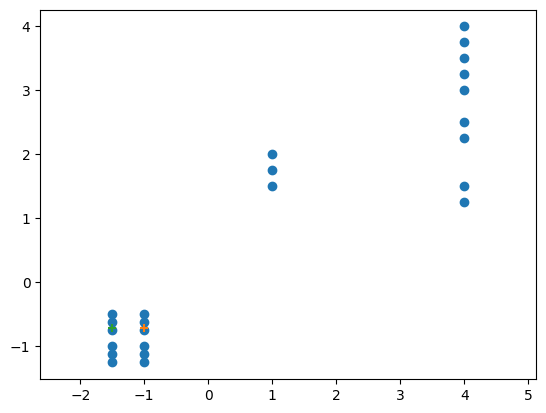

In [19]:
def plot_old_micro_clusters(micro_clusters):
    for cluster in micro_clusters.values():
        center = cluster.calc_center(0)
        center = np.array(list(center.values()))
        radius = cluster.calc_radius(0)
        weight = cluster.calc_weight(0)
        center_point = plt.scatter(*center, marker="+", alpha=1)
        circle = plt.Circle(center, radius, fill=True, alpha=0.25, color=center_point.get_facecolor())
        plt.gca().add_patch(circle)
        plt.axis('equal')

plt.scatter(*np.array(X).T)
plot_old_micro_clusters(old_clusterer.p_micro_clusters)
plt.show()

Our algorithm seems to do better as well. I may be accidentally using the old one wrong, but I'm pretty sure I'm not.

## Recluster

Do debugging/testing of the `_recluster` method.

In [20]:
X = np.array([
    [-1, -0.5], [-1, -0.625], [-1, -0.75], [-1, -1], [-1, -1.125],
    [-1, -1.25], [-1.5, -0.5], [-1.5, -0.625], [-1.5, -0.75], [-1.5, -1],
    [-1.5, -1.125], [-1.5, -1.25], [1, 1.5], [1, 1.75], [1, 2],
    [4, 1.25], [4, 1.5], [4, 2.25], [4, 2.5], [4, 3],
    [4, 3.25], [4, 3.5], [4, 3.75], [4, 4],
])

def new_default_clusterer():
    clusterer = DenStream(
        decaying_factor = 0.25,
        beta = .5,
        mu = 2.5,
        epsilon = .5,
        n_samples_init = len(X),
        stream_speed = 100,
    )
    clusterer._init_buffer = X
    clusterer._initial_dbscan()
    clusterer.initialized = True
    return clusterer

Weights: [12.0, 3.0, 2.0, 7.0]
# Core Clusters: 3
# Clusters: 3


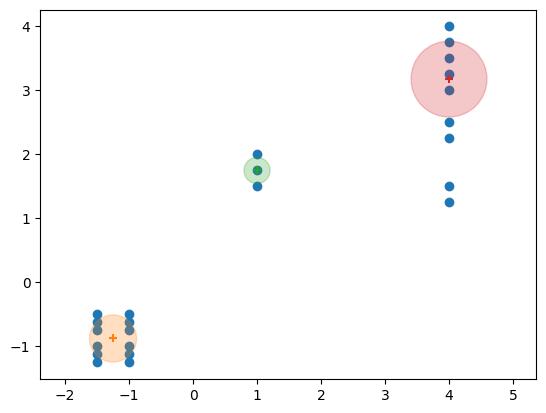

In [21]:
clusterer = new_default_clusterer()
print("Weights:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("# Core Clusters:", len(clusterer._get_core_clusters(clusterer.p_micro_clusters)))

clusterer._recluster()                          # Correctly drops the non-core micro-cluster
print("# Clusters:", len(clusterer.clusters))   # Other micro-clusters are too far to be merged

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.clusters)
plt.show()

Weights: [12.0, 3.0, 2.0, 7.0, 3.0]
# Core Clusters: 4
# Clusters: 3


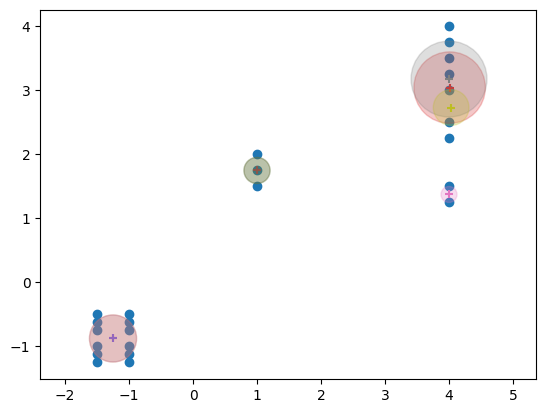

In [22]:
clusterer = new_default_clusterer()

# Create an artificial micro-cluster that is close enough to merge
pmc = DenStreamMicroCluster(
    X = np.array([[4.1,3.1],[4.1,2.6],[3.9,2.5]]),
    timestamp = 0,
    decaying_factor = clusterer.decaying_factor,
)
clusterer.p_micro_clusters.append(pmc)

print("Weights:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("# Core Clusters:", len(clusterer._get_core_clusters(clusterer.p_micro_clusters)))

clusterer._recluster()                          # Correctly drops the non-core micro-cluster
print("# Clusters:", len(clusterer.clusters))   # Merges the two close core-micro-clusters

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.clusters)         # Plot both the final clusters and the p-micro-clusters
plot_micro_clusters(clusterer.p_micro_clusters)
plt.show()

As I tested the above, I realized that using DBSCAN to initialize p-micro-clusters as above can result in p-micro-clusters that do not satisfy the condition that $r < \epsilon$. Thus, those micro-clusters are deleted the next time pruning is done. Though this method is nice to allow parallel distance computations, it may be better to just incrementally add points to the o-micro-clusters and allow those to grow into p-micro-clusters.

### Check that the other implementations are correct

Weights: [12.0, 3.0, 2.0, 7.0, 3.0]
# Core Clusters: 4
# Clusters: 3


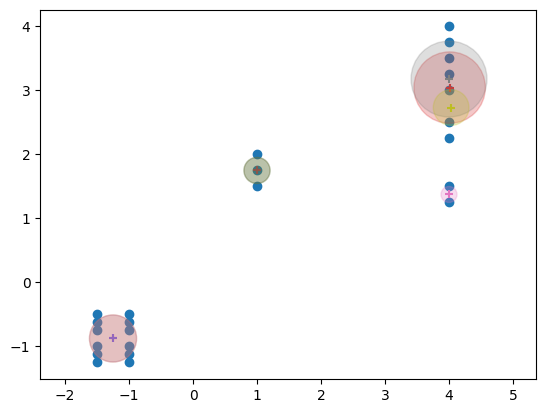

In [23]:
clusterer = new_default_clusterer()

# Check the Scipy implementation
pmc = DenStreamMicroCluster(
    X = np.array([[4.1,3.1],[4.1,2.6],[3.9,2.5]]),
    timestamp = 0,
    decaying_factor = clusterer.decaying_factor,
)
clusterer.p_micro_clusters.append(pmc)

print("Weights:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("# Core Clusters:", len(clusterer._get_core_clusters(clusterer.p_micro_clusters)))

clusterer._recluster_scipy()                    # Results appear consistent with the above
print("# Clusters:", len(clusterer.clusters))   # Still need to do runtime comparison on real data

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.clusters)
plot_micro_clusters(clusterer.p_micro_clusters)
plt.show()

Weights: [12.0, 3.0, 2.0, 7.0, 3.0]
# Core Clusters: 4
# Clusters: 3


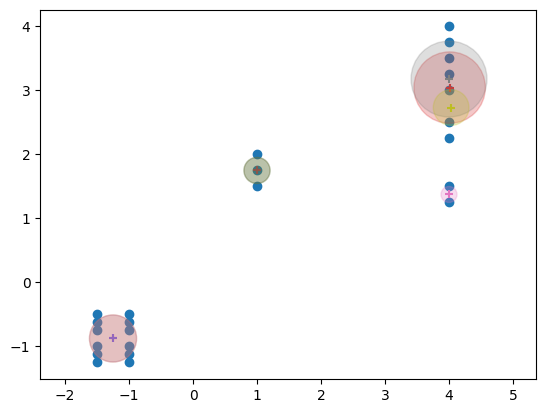

In [24]:
clusterer = new_default_clusterer()

# Check the nxgraph implementation
pmc = DenStreamMicroCluster(
    X = np.array([[4.1,3.1],[4.1,2.6],[3.9,2.5]]),
    timestamp = 0,
    decaying_factor = clusterer.decaying_factor,
)
clusterer.p_micro_clusters.append(pmc)

print("Weights:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("# Core Clusters:", len(clusterer._get_core_clusters(clusterer.p_micro_clusters)))

clusterer._recluster_nxgraph()                  # Results appear consistent with the above
print("# Clusters:", len(clusterer.clusters))   # Still need to do runtime comparison on real data

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.clusters)
plot_micro_clusters(clusterer.p_micro_clusters)
plt.show()

## Merge

Do debugging/testing of the `_merge` method.

Weights Before: [12.0, 3.0, 2.0, 7.0]
Radii Before: [0.368, 0.2041, 0.125, 0.5933]
Weights After: [12.0, 4.0, 2.0, 7.0]
Radii Before: [0.368, 0.2073, 0.125, 0.5933]


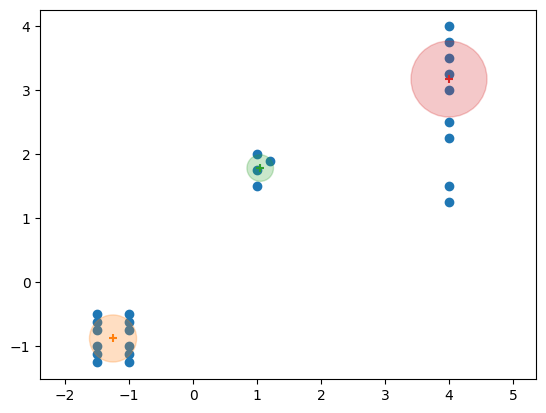

In [25]:
clusterer = new_default_clusterer()
print("Weights Before:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0),4) for mc in clusterer.p_micro_clusters])

# Merge a new point into the clustering
new_point = np.array([1.2, 1.9])
clusterer._merge(new_point)

print("Weights After:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0), 4) for mc in clusterer.p_micro_clusters])

clusterer._recluster()

plt.scatter(*np.array(X).T)
plt.scatter(*new_point, color="C0")
plot_micro_clusters(clusterer.clusters)
plt.show()

Weights Before: [12.0, 3.0, 2.0, 7.0]
Radii Before: [0.368, 0.2041, 0.125, 0.5933]
Weights After: [13.0, 4.0, 3.0, 7.0]
Radii Before: [0.3588, 0.2073, 0.1394, 0.5933]


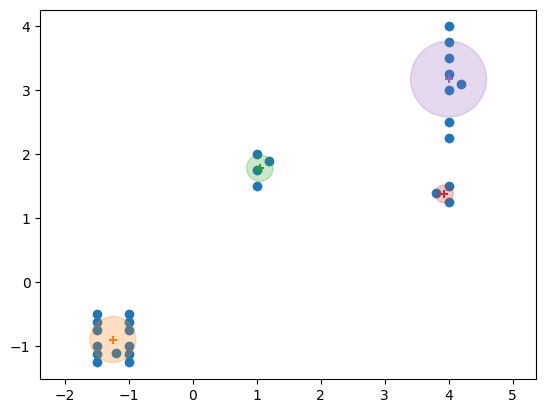

In [26]:
clusterer = new_default_clusterer()
print("Weights Before:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0),4) for mc in clusterer.p_micro_clusters])

# Merge multiple points into the clustering
new_points = np.array([[1.2, 1.9],[4.2, 3.1],[3.8, 1.4],[-1.2,-1.1]])
for x in new_points:
    clusterer._merge(x)

print("Weights After:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0), 4) for mc in clusterer.p_micro_clusters])

# Note that the red cluster is newly formed because the corresponding p-micro-cluster becomes a core cluster
clusterer._recluster()  

plt.scatter(*np.array(X).T)
plt.scatter(*new_points.T, color="C0")
plot_micro_clusters(clusterer.clusters)
plt.show()

Weights Before: [12.0, 3.0, 2.0, 7.0]
Radii Before: [0.368, 0.2041, 0.125, 0.5933]
Weights After: [12.0, 3.0, 2.0, 7.0]
Radii Before: [0.368, 0.2041, 0.125, 0.5933]
# Outlier Clusters: 1


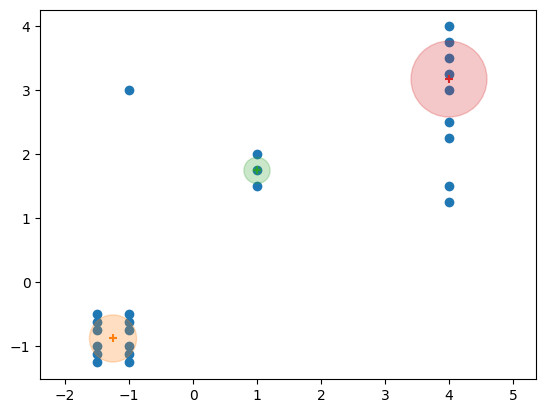

In [27]:
clusterer = new_default_clusterer()
print("Weights Before:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0),4) for mc in clusterer.p_micro_clusters])

# Merge point in that forms a new o-micro-cluster
outlier_point = np.array([-1., 3.])
clusterer._merge(outlier_point)

print("Weights After:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0), 4) for mc in clusterer.p_micro_clusters])
print("# Outlier Clusters:", len(clusterer.o_micro_clusters))

clusterer._recluster()

plt.scatter(*np.array(X).T)
plt.scatter(*outlier_point.T, color="C0")
plot_micro_clusters(clusterer.clusters)
plt.show()

Weights Before: [12.0, 3.0, 2.0, 7.0]
Radii Before: [0.368, 0.2041, 0.125, 0.5933]
Weights After: [12.0, 3.0, 2.0, 7.0, 4.0]
Radii Before: [0.368, 0.2041, 0.125, 0.5933, 0.1398]
# Outlier Clusters: 0


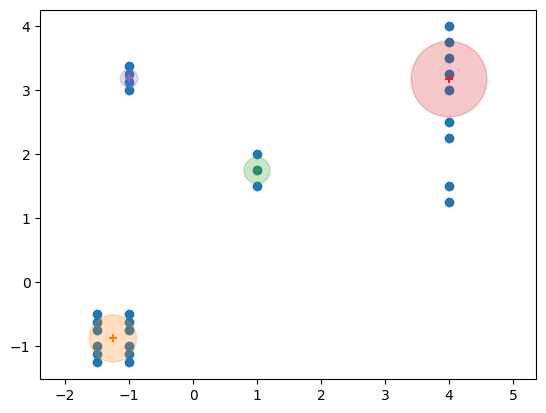

In [28]:
clusterer = new_default_clusterer()
print("Weights Before:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0),4) for mc in clusterer.p_micro_clusters])

# Merge multiple outlier points that eventually form a new cluster
outlier_points = np.array([[-1., 3.],[-1., 3.125],[-1., 3.25],[-1., 3.375]])
for x in outlier_points:
    clusterer._merge(x)

print("Weights After:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii Before:", [round(mc.calc_radius(0), 4) for mc in clusterer.p_micro_clusters])
print("# Outlier Clusters:", len(clusterer.o_micro_clusters))

clusterer._recluster()

plt.scatter(*np.array(X).T)
plt.scatter(*outlier_points.T, color="C0")
plot_micro_clusters(clusterer.clusters)
plt.show()

## Prune

Do debugging/testing of the `_prune` method.

Time Period Tp: 7
p-micro-cluster Threshold: 1.25
Weights (t=0): [12.0, 3.0, 2.0, 7.0]
Weights (t=7): [3.5676213450081633, 0.8919053362520408, 0.5946035575013605, 2.0811124512547616]
Weights (after prune): [3.5676213450081633, 2.0811124512547616]


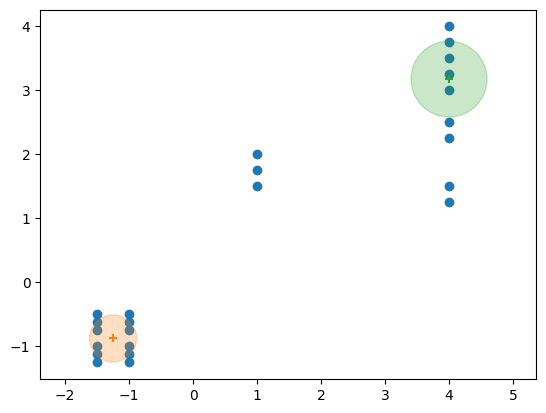

In [29]:
# Test pruning of decaying p-micro-clusters
clusterer = new_default_clusterer()
Tp = clusterer._time_period
print("Time Period Tp:", Tp)
print("p-micro-cluster Threshold:", clusterer.beta * clusterer.mu)
print("Weights (t=0):", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print(f"Weights (t={Tp}):", [mc.calc_weight(Tp) for mc in clusterer.p_micro_clusters])

clusterer.timestamp = Tp
clusterer._prune()

print("Weights (after prune):", [mc.calc_weight(clusterer.timestamp) for mc in clusterer.p_micro_clusters])

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.p_micro_clusters, t=Tp)
plt.show()

In [30]:
# Test that non-developing o-micro-clusters are pruned
clusterer = new_default_clusterer()
Tp = clusterer._time_period
print("Time Period Tp:", Tp)

# Add outlier
outlier_point = np.array([-1., 3.])
clusterer._merge(outlier_point)
print("# Outlier Clusters (t=0):", len(clusterer.o_micro_clusters))

clusterer.timestamp = Tp
clusterer._prune()
print(f"# Outlier Clusters (t={Tp}):", len(clusterer.o_micro_clusters))

Time Period Tp: 7
# Outlier Clusters (t=0): 1
# Outlier Clusters (t=7): 0


## Learn One

Do debugging/testing of the `learn_one` method.

Weights Before: [12.0, 3.0, 2.0, 7.0]


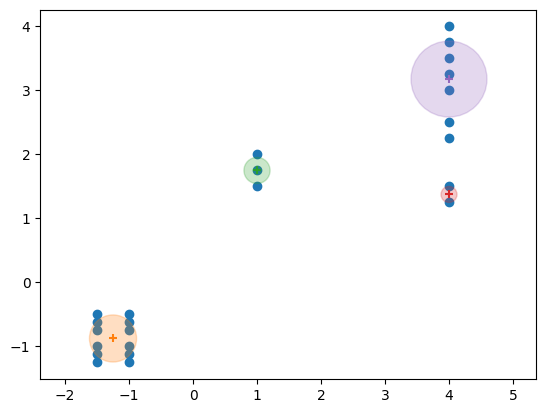

Weights After: [13.0, 4.0, 3.0, 7.0]


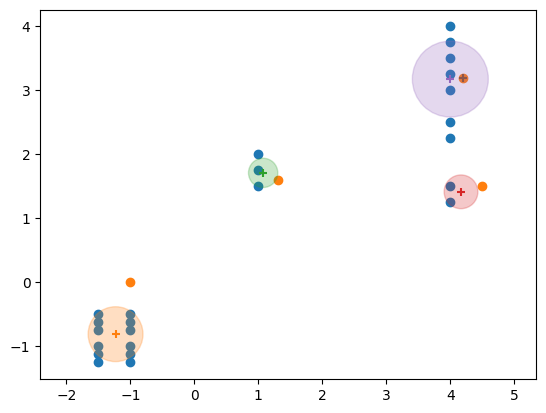

In [31]:
X_new = np.array([[-1,0],[1.3, 1.6],[4.5, 1.5],[4.2, 3.2]])

clusterer = new_default_clusterer()
print("Weights Before:", [mc.calc_weight(clusterer.timestamp) for mc in clusterer.p_micro_clusters])

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.p_micro_clusters, t=clusterer.timestamp)
plt.show()

for x in X_new:
    clusterer.learn_one(x)

print("Weights After:", [mc.calc_weight(clusterer.timestamp) for mc in clusterer.p_micro_clusters])
clusterer._recluster()

plt.scatter(*np.array(X).T)
plt.scatter(*X_new.T, color="C1")
plot_micro_clusters(clusterer.p_micro_clusters, t=clusterer.timestamp)
plot_micro_clusters(clusterer.o_micro_clusters, t=clusterer.timestamp)

The above result indicates one of the problems with DBSCAN initialization of the p-micro-clusters. Since the upper right p-micro-cluster is initialized with a radius greater than $\epsilon$, no new points, even those that are very close to the center of the p-micro-cluster can be added to it, since adding another point still results in a p-micro-cluster with radius greater than $\epsilon$. In fact, adding back the same points that were used in initialization results in different p-micro-clusters overlapping the existing p-micro-cluster in that area. This ultimately results in the p-micro-cluster being left unchanged until the first pruning step, when it is removed.

*Edit*: p-micro-clusters are not actually pruned if their radius is greater than $\epsilon$, since it is assumed that they cannot even get to that point. If it were not for the poor initialization this would be a good assumption. However, even if the p-micro-cluster is not pruned, this results in an inactive p-micro-cluster that is not updated and eventually just fades out.

*Note*: Our implementation would benefit greatly from a batch version of the `learn_one` method; however, as each update changes the locations and distances for each micro-cluster, it is not possible to create a pure implementation of the batch version that would be more efficient than just looping over the batch elements. If we need a batch implementation, we could instead look into faster method that approximates the results of the looped learn_one method, but the results would not be the same as learning one at a time.

## Predict

Do debugging/testing of the `predict` and `predict_one` methods.

# Clusters: 3
Epsilon: 0.5
Predictions: [-1, 1, -1, 2]


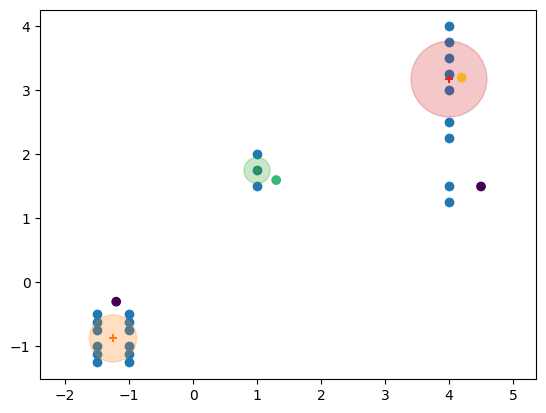

In [32]:
X_new = np.array([[-1.2,-.3],[1.3, 1.6],[4.5, 1.5],[4.2, 3.2]])

clusterer = new_default_clusterer()
clusterer._recluster()
print("# Clusters:", len(clusterer.clusters))
clusterer.epsilon = .5
print("Epsilon:", clusterer.epsilon)

predictions = []
for x in X_new:
    predictions.append(clusterer.predict_one(x))

print("Predictions:", predictions)

plt.scatter(*np.array(X).T)
plt.scatter(*X_new.T, c=predictions)
plot_micro_clusters(clusterer.clusters, t=clusterer.timestamp)

# Clusters: 3
Epsilon: 0.5
Predictions: [-1  1 -1  2]


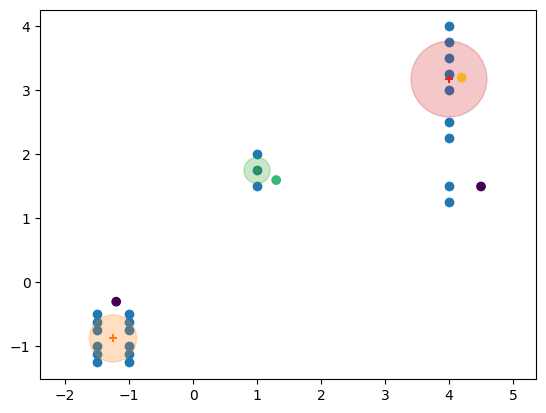

In [33]:
X_new = np.array([[-1.2,-.3],[1.3, 1.6],[4.5, 1.5],[4.2, 3.2]])

clusterer = new_default_clusterer()
clusterer._recluster()
print("# Clusters:", len(clusterer.clusters))
clusterer.epsilon = .5
print("Epsilon:", clusterer.epsilon)

predictions = clusterer.predict(X_new)
print("Predictions:", predictions)

plt.scatter(*np.array(X).T)
plt.scatter(*X_new.T, c=predictions)
plot_micro_clusters(clusterer.clusters, t=clusterer.timestamp)

## Alternative Changes

### Blind Initialization

Weights: [6.0, 6.0, 3.0, 2.0, 2.0, 4.0]
Radii: [0.27, 0.27, 0.2041, 0.125, 0.125, 0.2795]
# Outlier Clusters: 1
Weights After: [6.0, 6.0, 3.0, 2.0, 2.0, 4.0]
Radii After: [0.27, 0.27, 0.2041, 0.125, 0.125, 0.2795]
# Outlier Clusters: 2


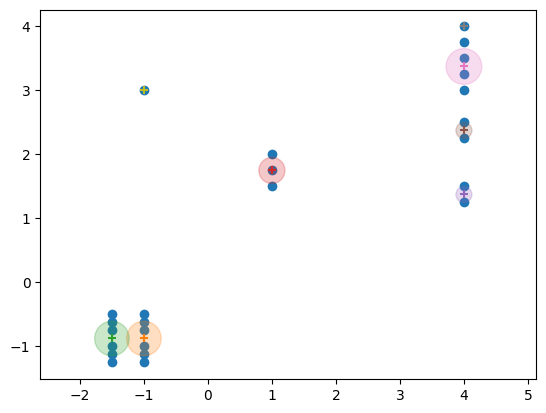

In [34]:
clusterer = DenStream(
    decaying_factor = 0.25,
    beta = .5,
    mu = 2.5,
    epsilon = .3,
    n_samples_init = len(X),
    stream_speed = 100,
)
clusterer.initialized = True

for x in X:
    clusterer._merge(x)

print("Weights:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii:", [round(mc.calc_radius(0), 4) for mc in clusterer.p_micro_clusters])
print("# Outlier Clusters:", len(clusterer.o_micro_clusters))

# Merge in outlier point
outlier_point = np.array([-1., 3.])
clusterer._merge(outlier_point)

print("Weights After:", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print("Radii After:", [round(mc.calc_radius(0), 4) for mc in clusterer.p_micro_clusters])
print("# Outlier Clusters:", len(clusterer.o_micro_clusters))

clusterer._recluster()

plt.scatter(*np.array(X).T)
plt.scatter(*outlier_point.T, color="C0")
plot_micro_clusters(clusterer.p_micro_clusters)
plot_micro_clusters(clusterer.o_micro_clusters)
plt.show()

### Safe Pruning

Time Period Tp: 7
p-micro-cluster Threshold: 1.25
Weights (t=0): [12.0, 3.0, 2.0, 7.0]
Weights (t=7): [3.5676213450081633, 0.8919053362520408, 0.5946035575013605, 2.0811124512547616]
# of Outlier Clusters: 0
Weights (after prune): [3.5676213450081633, 2.0811124512547616]
# of Outlier Clusters: 0


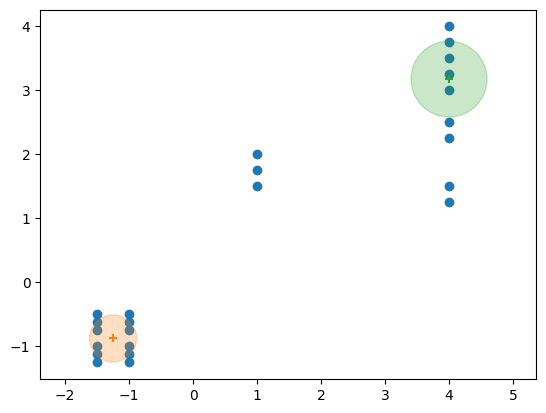

In [35]:
clusterer = new_default_clusterer()
Tp = clusterer._time_period
print("Time Period Tp:", Tp)
print("p-micro-cluster Threshold:", clusterer.beta * clusterer.mu)
print("Weights (t=0):", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print(f"Weights (t={Tp}):", [mc.calc_weight(Tp) for mc in clusterer.p_micro_clusters])
print("# of Outlier Clusters:", len(clusterer.o_micro_clusters))

clusterer.timestamp = Tp
clusterer._prune_safe()     # In this case, the result is the same, since they p_micro_clusters have decayed even past the outlier threshold

print("Weights (after prune):", [mc.calc_weight(clusterer.timestamp) for mc in clusterer.p_micro_clusters])
print("# of Outlier Clusters:", len(clusterer.o_micro_clusters)) 

plt.scatter(*np.array(X).T)
plot_micro_clusters(clusterer.p_micro_clusters, t=Tp)
plt.show()

Time Period Tp: 7
p-micro-cluster Threshold: 1.25
Weights (t=0): [12.0, 3.0, 2.0, 7.0]
Weights (t=7): [3.5676213450081633, 0.8919053362520408, 0.5946035575013605, 2.0811124512547616]
# of Outlier Clusters: 1
Weights (after prune): [3.5676213450081633, 2.0811124512547616, 1.7328017515057552]
# of Outlier Clusters: 0


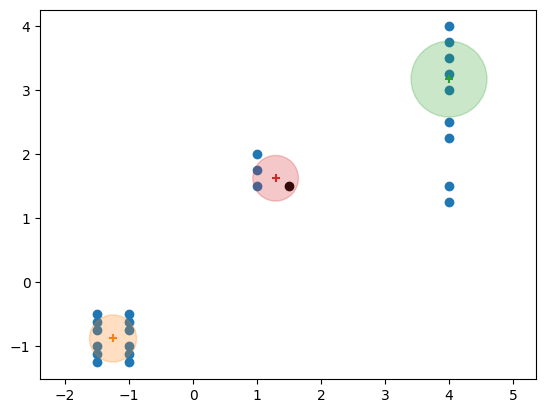

In [36]:
clusterer = new_default_clusterer()
Tp = clusterer._time_period
clusterer.o_micro_clusters.append(DenStreamMicroCluster(    # Insert a close outlier cluster
    X = np.array([1.6,1.5]),
    timestamp = 6,
    decaying_factor = clusterer.decaying_factor,
))
print("Time Period Tp:", Tp)
print("p-micro-cluster Threshold:", clusterer.beta * clusterer.mu)
print("Weights (t=0):", [mc.calc_weight(0) for mc in clusterer.p_micro_clusters])
print(f"Weights (t={Tp}):", [mc.calc_weight(Tp) for mc in clusterer.p_micro_clusters])
print("# of Outlier Clusters:", len(clusterer.o_micro_clusters))

clusterer.timestamp = Tp
clusterer._prune_safe()   

# Saves the p-micro-cluster that is decaying by merging it with the nearby outlier cluster
# Furthermore, the addition of the outlier cluster makes it still a p-micro-cluster
# This way, the data of the points in that micro cluster is not lost

print("Weights (after prune):", [mc.calc_weight(clusterer.timestamp) for mc in clusterer.p_micro_clusters])
print("# of Outlier Clusters:", len(clusterer.o_micro_clusters)) 

plt.scatter(*np.array(X).T)
plt.scatter(1.5, 1.5, color="k")
plot_micro_clusters(clusterer.p_micro_clusters, t=Tp)
plot_micro_clusters(clusterer.o_micro_clusters, t=Tp)
plt.show()

## Problems

### Radius with Highly-Weighted Clusters

In [163]:
temp = np.random.rand(1000,48)
cluster = DenStreamMicroCluster(
    X= temp,
    timestamp=1,
    decaying_factor=0.5,
)
center = cluster.calc_center(1)
print("Center:", center)
print("Mean Dist from Center:", np.mean([np.linalg.norm(x-center) for x in temp]))
print("Radius:", cluster.calc_radius(1))

new_point = np.random.rand(48)*10
cluster.insert(new_point, timestamp=1)
center = cluster.calc_center(1)
print("Center:", center)
print("Dist from Center:", np.linalg.norm(new_point-center))
print("Mean Dist from Center:", np.mean([np.linalg.norm(x-center) for x in temp] + [np.linalg.norm(new_point-center)]))
print("Radius:", cluster.calc_radius(1))
# print("Dist/2 ~= Radius:", np.allclose(cluster.calc_radius(1), np.linalg.norm(a-b)/2))

Center: [0.49813779 0.4972244  0.51748695 0.4965707  0.50045153 0.49578728
 0.503198   0.50866047 0.49974905 0.49010749 0.49323243 0.50743824
 0.49974218 0.50319107 0.49969909 0.5112407  0.48775356 0.49626396
 0.49982731 0.48773451 0.49638689 0.50985008 0.50572369 0.50066912
 0.50098369 0.51213063 0.50048431 0.48829181 0.48780909 0.49453766
 0.4903648  0.49022832 0.50927976 0.50338814 0.50134249 0.49249708
 0.51155554 0.49462682 0.50916072 0.52553397 0.48531995 0.5077226
 0.50828356 0.50678887 0.50673485 0.49412845 0.49864956 0.51963598]
Mean Dist from Center: 1.9931103793652662
Radius: 1.9974337151692818
Center: [0.66464164 0.60974786 0.63480378 0.52142216 0.56074651 0.62384751
 0.57225249 0.66724891 0.51712708 0.53037455 0.68114369 0.49835665
 0.68211335 0.5185965  0.67204119 0.66660864 0.50178641 0.60675312
 0.4969983  0.58278418 0.64962538 0.56301818 0.59674106 0.63796924
 0.71068616 0.71726615 0.55327129 0.62372315 0.49334342 0.51822957
 0.54890656 0.48212079 0.6030213  0.49852351

In the above, despite the fact that the new point being added to the cluster is very far from the cluster center (around 40 units), the radius does not increase by much, since the radius is an approximation of the average distance of the points in the cluster to the cluster center. That said, this may be mitigated mostly by the decaying of points in the past. Maybe this is more of a way to choose the decay rate and stream speed in such a way that the radius of accepting points into a cluster is reasonable.